### 교차검증: 데이터 적을 때 사용

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml
# https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True,return_X_y=True)
df=pd.concat([X,y],axis=1)
df

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None,0
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None,0
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None,0
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None,0


In [2]:
df.columns

Index(['pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare',
       'cabin', 'embarked', 'boat', 'body', 'home.dest', 'survived'],
      dtype='object')

In [3]:
train_cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
X = df[train_cols] # 독립변수
y = df["survived"]
y.value_counts()

0    809
1    500
Name: survived, dtype: int64

c:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='survived', ylabel='count'>

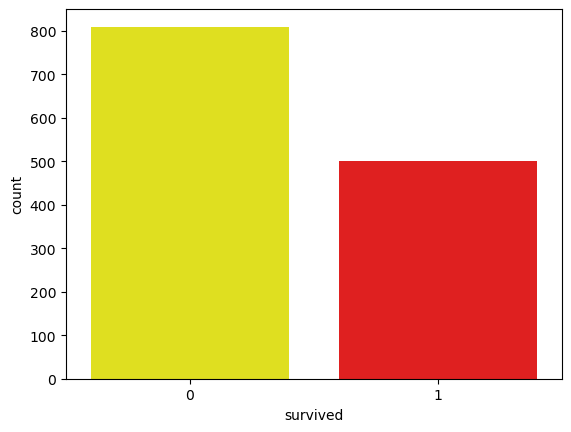

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
colors = ["yellow", "red"]
sns.countplot('survived', data=df, palette=colors)

In [5]:
#언더샘플링
from imblearn.under_sampling import RandomUnderSampler
X_sample, y_sample = RandomUnderSampler(random_state=0).fit_resample(X, y)
X_samp = pd.DataFrame(data=X_sample,columns=train_cols )
y_samp = pd.DataFrame(data=y_sample,columns=['survived'])
df2=pd.concat([X_samp,y_samp],axis=1)

In [6]:
X = df2[train_cols] # 독립변수
y = df2["survived"]
y.value_counts()

0    500
1    500
Name: survived, dtype: int64

c:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='survived', ylabel='count'>

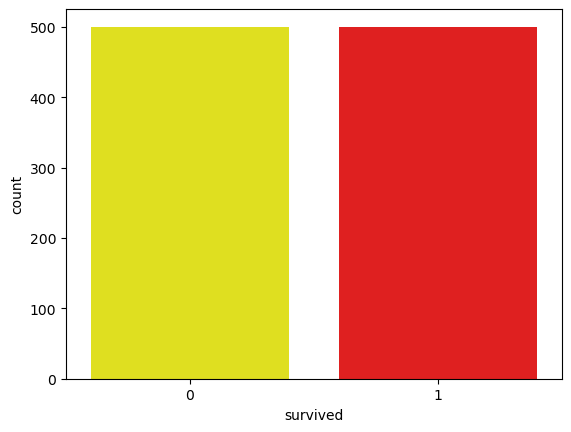

In [7]:
colors = ["yellow", "red"]
sns.countplot('survived', data=df2, palette=colors)

In [9]:
X = X_samp[train_cols] # 독립변수
y = y_samp["survived"]

In [10]:
#데이터 전처리 자동화
#연속된 변환을 순서대로 처리하는 클래스
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

In [11]:
#결측값 처리 - 나이, 요금(중위수로 처리)
#스케일링
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [12]:
#범주형 변수 - 원핫인코딩
# embarked: {'C', 'S', 'Q'}
# sex: {'female', 'male'}
# pclass: {1, 2, 3}
# handle_unknown='ignore' 변환 중에 에러가 발생할 경우 무시하고 계속 진행
categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # 최빈수로 채우기
    ('onehot', OneHotEncoder(handle_unknown='ignore'))]) 

preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    # 변수  수치형변환 파이프라인   변수 목록
    ('cat', categorical_transformer, 
    categorical_features)])

In [13]:
# 전처리 후 로지스틱 회귀분석 분류모형
clf = Pipeline(steps=[('preprocessor', preprocessor), # 전처리 작업
('classifier', LogisticRegression())])
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'se

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.76625
0.775


In [15]:
#교차검증과 모형의 튜닝
#하이퍼 파라미터 최적화
from sklearn.model_selection import GridSearchCV
# 숫자 결측값 처리
# Cost
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search.fit(X, y)
grid_search.cv_results_["params"]

[{'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.0001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.001, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.01, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 1.0, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 10, 'preprocessor__num__imputer__strategy': 'median'},
 {'classifier__C': 100, 'preprocessor__num__imputer__strategy': 'mean'},
 {'classifier__C': 100, 'prep

In [16]:
scores=grid_search.cv_results_["mean_test_score"]
scores

array([0.727, 0.728, 0.748, 0.748, 0.75 , 0.75 , 0.754, 0.75 , 0.754,
       0.753, 0.754, 0.753, 0.754, 0.753])

0.7540000000000001


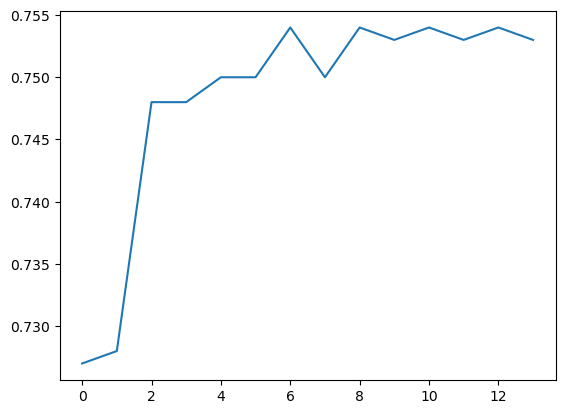

In [17]:
print(max(scores))
plt.plot(scores)

In [18]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7540000000000001
{'classifier__C': 0.1, 'preprocessor__num__imputer__strategy': 'mean'}
